# TP2 - Détection et reconnaissance d'images et vidéos

## 0. Import des libraires

In [1]:
import cv2 as cv
import imutils
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

## 1. Création de nos classes

### 1.1. Classe pour le traitement des images

In [59]:
class Imaginator:
    def __init__(self, img_path: str) -> None:
        """Constructeur de la classe Imaginator

        Args:
            img_path (str): Chemin relatif de l'image
        """
        self.img = cv.imread(img_path)
    
    def convert_to_gray(self):
        """convert_to_gray: On convertit l'image en noir et blanc
        """
        self.img = cv.cvtColor(self.img, cv.COLOR_BGR2GRAY)
    
    def convert_to_rgb(self):
        """convert_to_rgb: On convertit l'image en mode RGB
        """
        self.img = cv.cvtColor(self.img, cv.COLOR_BGR2RGB)
    
    def add_gaussian_blur_filter(self, kernel_size: int):
        """add_gaussian_blur_filter: Applique un filtre de flou gaussien

        Args:
            kernel_size (int): Niveau de flou
        """
        self.img = cv.GaussianBlur(self.img, (kernel_size, kernel_size), 0)
    
    def add_canny_filter(self, min_val: int, max_val: int):
        """add_canny_filter: Applique un filtre Canny (de contour)

        Args:
            min_val (int): Valeur minimum
            max_val (int): Valeur maximum
        """
        self.img = cv.Canny(self.img, min_val, max_val)
    
    def add_sobel_filter(self):
        """add_sobel_filter: Applique un filtre Sobel (de contour)
        """
        x = cv.Sobel(self.img, cv.CV_64F, 1, 0, ksize=3)
        y = cv.Sobel(self.img, cv.CV_64F, 0, 1, ksize=3)
        self.img = cv.magnitude(x, y)

    def add_binary_threshold_filter(self, threshold: int):
        """add_binary_threshold_filter: Applique un filtre de seuillage (en mode binaire)

        Args:
            threshold (int): Niveau de seuillage
        """
        _, self.img = cv.threshold(self.img, threshold, 255, cv.THRESH_BINARY)
    
    def add_adaptative_threshold_filter(self, block_size: int, constant: int):
        """add_adaptative_threshold_filter: Applique un filtre de seuillage (en mode adaptatif)

        Args:
            block_size (int): Taille de bloc
            constant (int): Valeur de calcul du seuil adaptatif
        """
        self.img = cv.adaptiveThreshold(self.img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, block_size, constant)

    def hog(self):
        """hog: Affiche les caractéritiques HOG d'une image
        """
        hog = cv.HOGDescriptor()
        hog.setSVMDetector(cv.HOGDescriptor_getDefaultPeopleDetector())

        self.img = imutils.resize(self.img, width=min(400, self.img.shape[1]))

        img_gray = cv.cvtColor(self.img, cv.COLOR_BGR2GRAY)

        rects, weights = hog.detectMultiScale(img_gray, winStride=(2, 2), padding=(10, 10), scale=1.02)

        for i, (x, y, w, h) in enumerate(rects):
            if weights[i] < 0.13:
                cv.rectangle(self.img, (x-5, y-10), (x+w, y+h), (0, 0, 255), 2)
                cv.putText(self.img, f"{weights[i]:.3f}", (x, y), cv.FONT_HERSHEY_DUPLEX, 0.4, (50, 122, 255), 2, cv.LINE_4)
            elif weights[i] < 0.3 and weights[i] > 0.13:
                cv.rectangle(self.img, (x-5, y-10), (x+w, y+h), (0, 165, 255), 2)
                cv.putText(self.img, f"{weights[i]:.3f}", (x, y), cv.FONT_HERSHEY_DUPLEX, 0.4, (50, 122, 255), 2, cv.LINE_4)
            
            if weights[i] < 0.7 and weights[i] > 0.3:
                cv.rectangle(self.img, (x-5, y-10), (x+w, y+h), (0, 255, 255), 2)
                cv.putText(self.img, f'{weights[i]:.3f}',(x, y), cv.FONT_HERSHEY_DUPLEX, 0.4, (50, 122, 255), 2, cv.LINE_4)
            if weights[i] > 0.7:
                cv.rectangle(self.img, (x-5, y-10), (x+w, y+h), (0, 255, 0), 2)
                cv.putText(self.img, f'{weights[i]:.3f}',(x, y), cv.FONT_HERSHEY_DUPLEX, 0.4, (0, 255, 0), 2, cv.LINE_4)

    def pedestrian_detection(self):
        """pedestrian_detection: Détction des personnes à l'aide du model YOLOv4
        """
        weights_path = 'yolo-model/yolov4-tiny.weights'
        config_path = 'yolo-model/yolov4-tiny.cfg'

        class_names = []
        with open('yolo-model/coco.names', 'r') as f:
            for line in f:
                class_names.append(line.strip())
        
        (H, W) = self.img.shape[:2]

        model = cv.dnn.readNetFromDarknet(config_path, weights_path)

        blob = cv.dnn.blobFromImage(self.img, 1 / 255.0, (416, 416), swapRB=True, crop=False)

        model.setInput(blob)

        layer_names = model.getLayerNames()

        layer_outputs = [layer_names[i - 1] for i in model.getUnconnectedOutLayers()]

        detections = model.forward(layer_outputs)

        boxes = []
        confidences = []
        class_ids = []

        for output in detections:
            for detection in output:
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]

                if classID == 0 and confidence > 0.5:
                    box = detection[0:4] * np.array([W, H, W, H])
                    (centerX, centerY, width, height) = box.astype('int')

                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))

                    boxes.append([x, y, int(width), int(height)])
                    class_ids.append(classID)
                    confidences.append(float(confidence))
        
        indices = cv.dnn.NMSBoxes(boxes, confidences, 0.2, 0.3)

        for i in indices:
            i = int(i)
            (x, y, w, h) = boxes[i]
            cv.rectangle(self.img, (x-5, y-10), (x+w, y+h), (0, 255, 0), 2)
            cv.putText(self.img, class_names[class_ids[i]], (x, y), cv.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0), 2, cv.LINE_4)

    def show(self, title: str = ""):
        """show: Affichage de l'image

        Args:
            title (str, optional): Titre de l'image. La valeur par défaut est "".
        """
        plt.imshow(self.img)
        plt.title(title)
        plt.axis('off')
        plt.show()

### 1.2. Classe pour le traitement des vidéos

In [55]:
class Videorator:
    def __init__(self) -> None:
        """Constructeur de la classe Videorator
        """
        pass
    
    def __canny_filter(self, img):
        """__canny_filter: (private) Applique un filtre Canny

        Args:
            img: Objet de l'image

        Returns:
            MatLike: Retourne l'objet de l'image
        """
        image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        image = cv.GaussianBlur(image, (5, 5), 0)
        image = cv.Canny(image, 30, 150)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        return image
    
    def __threshold_binary_filter(self, img):
        """__threshold_binary_filter: (private) Applique un filtre de seuillage binaire

        Args:
            img: Objet de l'image (OpenCV)

        Returns:
            MatLike: Retourne l'objet de l'image
        """
        image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        _, image = cv.threshold(image, 127, 255, cv.THRESH_BINARY)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        return image
    
    def __hog(self, img):
        """__hog: (private) Affiche les caractéristiques HOG d'une vidéo

        Args:
            img: Objet image (OpenCV)

        Returns:
            MatLike: Objet image
        """
        hog = cv.HOGDescriptor()
        hog.setSVMDetector(cv.HOGDescriptor_getDefaultPeopleDetector())

        img = imutils.resize(img, width=min(400, img.shape[1]))

        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        rects, weights = hog.detectMultiScale(img_gray, winStride=(2, 2), padding=(10, 10), scale=1.02)

        for i, (x, y, w, h) in enumerate(rects):
            if weights[i] < 0.13:
                cv.rectangle(img, (x-5, y-10), (x+w, y+h), (0, 0, 255), 2)
                cv.putText(img, f"{weights[i]:.3f}", (x, y), cv.FONT_HERSHEY_DUPLEX, 0.4, (50, 122, 255), 2, cv.LINE_4)
            elif weights[i] < 0.3 and weights[i] > 0.13:
                cv.rectangle(img, (x-5, y-10), (x+w, y+h), (0, 165, 255), 2)
                cv.putText(img, f"{weights[i]:.3f}", (x, y), cv.FONT_HERSHEY_DUPLEX, 0.4, (50, 122, 255), 2, cv.LINE_4)
            
            if weights[i] < 0.7 and weights[i] > 0.3:
                cv.rectangle(img, (x-5, y-10), (x+w, y+h), (0, 255, 255), 2)
                cv.putText(img, f'{weights[i]:.3f}',(x, y), cv.FONT_HERSHEY_DUPLEX, 0.4, (50, 122, 255), 2, cv.LINE_4)
            if weights[i] > 0.7:
                cv.rectangle(img, (x-5, y-10), (x+w, y+h), (0, 255, 0), 2)
                cv.putText(img, f'{weights[i]:.3f}',(x, y), cv.FONT_HERSHEY_DUPLEX, 0.4, (0, 255, 0), 2, cv.LINE_4)
        return img
    
    def __yolo(self, img):
        """__yolo: (private) Détection des personnes à l'aide du model YOLOv4

        Args:
            img: Objet image (OpenCV)

        Returns:
            MatLike: Objet image
        """
        weights_path = 'yolo-model/yolov4-tiny.weights'
        config_path = 'yolo-model/yolov4-tiny.cfg'

        class_names = []
        with open('yolo-model/coco.names', 'r') as f:
            for line in f:
                class_names.append(line.strip())
        
        (H, W) = img.shape[:2]

        model = cv.dnn.readNetFromDarknet(config_path, weights_path)

        blob = cv.dnn.blobFromImage(img, 1 / 255.0, (416, 416), swapRB=True, crop=False)

        model.setInput(blob)

        layer_names = model.getLayerNames()

        layer_outputs = [layer_names[i - 1] for i in model.getUnconnectedOutLayers()]

        detections = model.forward(layer_outputs)

        boxes = []
        confidences = []
        class_ids = []

        for output in detections:
            for detection in output:
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]

                if classID == 0 and confidence > 0.5:
                    box = detection[0:4] * np.array([W, H, W, H])
                    (centerX, centerY, width, height) = box.astype('int')

                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))

                    boxes.append([x, y, int(width), int(height)])
                    class_ids.append(classID)
                    confidences.append(float(confidence))
        
        indices = cv.dnn.NMSBoxes(boxes, confidences, 0.2, 0.3)

        for i in indices:
            i = int(i)
            (x, y, w, h) = boxes[i]
            cv.rectangle(img, (x-5, y-10), (x+w, y+h), (0, 255, 0), 2)
            cv.putText(img, class_names[class_ids[i]], (x, y), cv.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0), 2, cv.LINE_4)
        return img
    
    def __show(self, frame, title: str = "") -> None:
        """__show: (private) On affiche la vidéo

        Args:
            frame: Objet de l'image
            title (str, optional): Titre de la vidéo. La valeur par défaut est "".
        """
        plt.imshow(frame)
        plt.title(title)
        plt.axis('off')
        plt.show()

    def detect_video_filter(self, video_path: str, filter: str = "", title: str = "") -> None:
        """detect_video: Lit la vidéo en appliquant en éventuel filtre

        Args:
            video_path (str): Chemin relatif de la vidéo
            filter (str, optional): Nom du filtre. La valeur par défaut est "".
            title (str, optional): Titre de la vidéo. La valeur par défaut est "".
        """
        cap = cv.VideoCapture(video_path)
        try:
            while(True):
                ret, frame = cap.read()

                if not ret:
                    cap.release()
                    break
                
                if filter == "":
                    pass
                elif filter == 'canny':
                    frame = self.__canny_filter(frame)
                elif filter == 'thresh_binary':
                    frame = self.__threshold_binary_filter(frame)

                self.__show(frame, title=title)

                clear_output(wait=True)
        except KeyboardInterrupt:
            cap.release()
            print("Released Video Ressource")
    
    def detect_video_hog(self, video_path: str, title: str = ""):
        cap = cv.VideoCapture(video_path)

        try:
            while(True):
                ret, frame = cap.read()

                if not ret:
                    cap.release()
                    break

                frame = self.__hog(frame)

                self.__show(frame, title=title)

                clear_output(wait=True)
        except KeyboardInterrupt:
            cap.release()
            print("Released Video Ressource")
    
    def detect_video_yolo(self, video_path: str, title: str = ""):
        cap = cv.VideoCapture(video_path)

        try:
            while(True):
                ret, frame = cap.read()

                if not ret:
                    cap.release()
                    break

                frame = self.__yolo(frame)

                self.__show(frame, title=title)

                clear_output(wait=True)
        except KeyboardInterrupt:
            cap.release()
            print("Released Video Ressource")

## 2. Traitement des images et vidéos

### 2.1. Application du filtre Canny

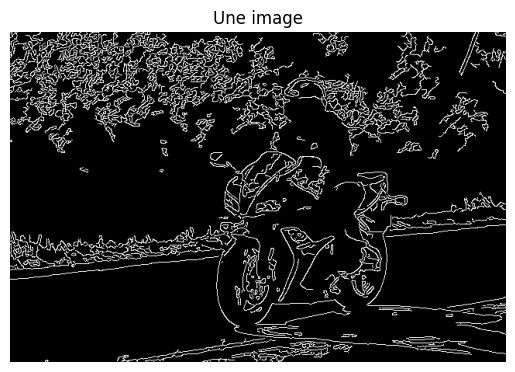

In [5]:
img_canny = Imaginator('images/motorbike.jpg')

# On convertit notre image en noir et blanc
img_canny.convert_to_gray()

# On applique un filtre de flou gaussien
img_canny.add_gaussian_blur_filter(5)

# On applique le filtre Canny
img_canny.add_canny_filter(30, 150)

# On convertit notre image aux couleurs d'origine
img_canny.convert_to_rgb()

# On affiche notre image
img_canny.show('Une image')

### 2.2. Application du filtre Sobel

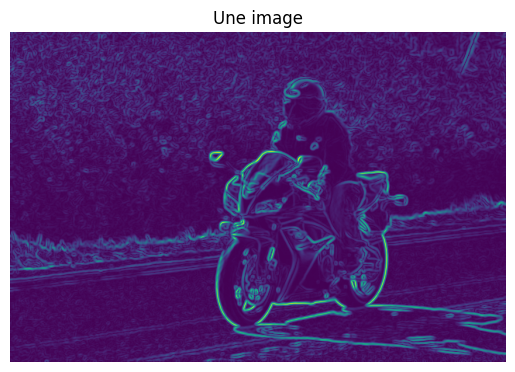

In [6]:
img_sobel = Imaginator('images/motorbike.jpg')

# On convertit notre image en noir et blanc
img_sobel.convert_to_gray()

# On applique un filtre de flou gaussien
img_sobel.add_gaussian_blur_filter(5)

# On applique le filtre Sobel
img_sobel.add_sobel_filter()

# On affiche notre image
img_sobel.show('Une image')

### 2.3. Application des filtres sur des vidéos

In [46]:
video = Videorator()

#### 2.3.1. Application du filtre Canny

In [47]:
video.detect_video_filter('videos/airport.mp4', title='Vidéo contourée', filter='canny')

Released Video Ressource


#### 2.3.2. Application du filtre de seuillage

In [48]:
video.detect_video_filter('videos/overpass.mp4', title='Vidéo seuillée', filter='thresh_binary')

Released Video Ressource


#### 2.3.3. Vidéo sans filtre

In [50]:
video.detect_video_filter('videos/car_chase_01.mp4', title='Vidéo sans filtre')

Released Video Ressource


### 2.4. Application du filtre de seuillage (binary)

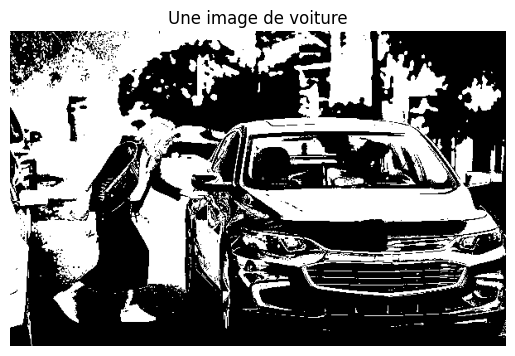

In [11]:
img_bin_threshold = Imaginator('images/car1.jpg')

# On convertit l'image en noir et blanc
img_bin_threshold.convert_to_gray()

# On applique le filtre de seuillage
img_bin_threshold.add_binary_threshold_filter(127)

# On convertit l'image en couleur d'origine
img_bin_threshold.convert_to_rgb()

# On affiche l'image
img_bin_threshold.show('Une image de voiture')

### 2.5. Application du filtre de seuillage (adaptative)

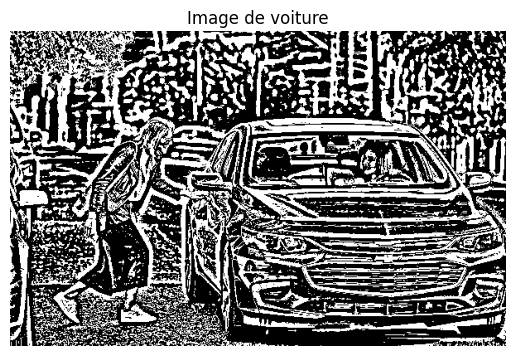

In [12]:
img_ada_threshold = Imaginator('images/car1.jpg')

# On convertit l'image en noir et blanc
img_ada_threshold.convert_to_gray()

# On applique le filtre de seuillage
img_ada_threshold.add_adaptative_threshold_filter(11, -2)

# On convertit l'image en couleur d'origine
img_ada_threshold.convert_to_rgb()

# On affiche l'image
img_ada_threshold.show('Image de voiture')

### 2.6. Calcul des caractéristiques HOG

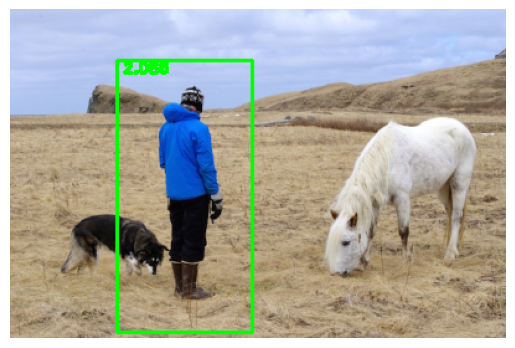

In [34]:
img_hog = Imaginator('images/person.jpg')

img_hog.convert_to_rgb()

img_hog.hog()

img_hog.show()

### 2.7. Utilisation du model YOLOv4

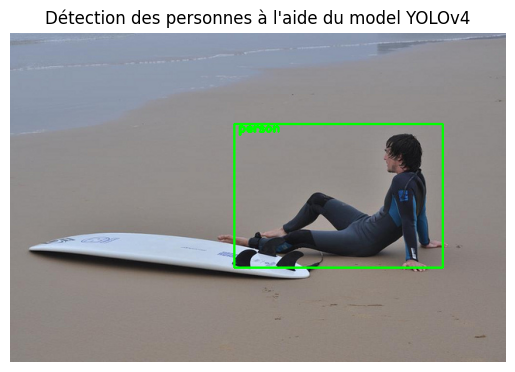

In [51]:
img_yolo = Imaginator('images/surf.jpg')

img_yolo.convert_to_rgb()

img_yolo.pedestrian_detection()

img_yolo.show("Détection des personnes à l'aide du model YOLOv4")

### 2.8. Caractéristiques HOG sur une vidéo

In [57]:
video = Videorator()

video.detect_video_hog("data/video4.mp4", title="Caractériques HOG sur une vidéo")

Released Video Ressource


### 2.9. YOLOv4 sur une vidéo

In [58]:
video = Videorator()

video.detect_video_yolo('data/video1.mp4', title='Détection des personnes avec YOLOv4')

Released Video Ressource
